In [1]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-atnmame8
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-atnmame8
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184182 sha256=3aefc2a43be9455c30f166114b172e13e6de4e2e56429ff2e9af0167992b78d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-09fwl0rk/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [2]:
# loading the mnist dataset
from tensorflow.keras.datasets.mnist import load_data

# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
 
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

11501568/11490434 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


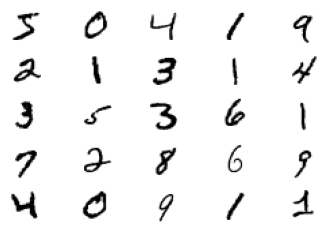

In [13]:
#plot of 25 images from the MNIST training dataset, arranged in a 5×5 square.
 
from tensorflow.keras.datasets.mnist import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(25):
  # define subplot
  pyplot.subplot(5, 5, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()


MNIST dataset to train the generator and the discriminator. The generator will generate Unique handwritten digits resembling the MNIST data.

In [14]:

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
 
from IPython import display

In [15]:
#setting the training space
(trn_imag, trn_labl), (_, _) = tf.keras.datasets.mnist.load_data()

In [16]:
trn_imag = trn_imag.reshape(trn_imag.shape[0], 28, 28, 1).astype('float32')
trn_imag = (trn_imag - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [17]:
#setting the buffer and batch size
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [18]:
# Batch and shuffle the data
trn_data = tf.data.Dataset.from_tensor_slices(trn_imag).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

The Generator
The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a random noise.

In [19]:
# input 7*7*256 (low resolution version of the output image)
# outputs a single 28×28 grayscale image
# this generator takes a vector of size 100 and first reshape that into (7, 7, 128) vector then applied transpose 
# convolution in combination with batch normalization. 


def genG_model():
    modelG = tf.keras.Sequential()
    modelG.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
 
    modelG.add(layers.Reshape((7, 7, 256)))
    assert modelG.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    modelG.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 7, 7, 128)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
 
   # upsample to 14x14
    modelG.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 14, 14, 64)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
    
    # upsample to 28x28
    modelG.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert modelG.output_shape == (None, 28, 28, 1)
 
    return modelG

Use the (as yet untrained) generator to create an image.

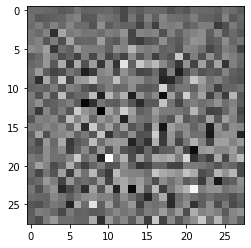

In [20]:
# sample image generated by the the generator
genG = genG_model()
 
noise = tf.random.normal([1, 100]) #latent space
generated_image = genG(noise, training=False)
 
plt.imshow(generated_image[0, :, :, 0], cmap='gray')


The Discriminator

The discriminator is a CNN-based image classifier.

In [21]:
# Input to discriminator = 28*28*1   grayscale image
# Output  binary prediction (image is real (class=1) or fake (class=0))
# no pooling layers  
# single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. 
# Downsampling from 28×28 to 14×14, then to 7×7, before the model makes an output prediction
def make_discriminator_model():
    modelD = tf.keras.Sequential()
    
    modelD.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1])) #2×2 stride to downsample
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))

    modelD.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))

    modelD.add(layers.Flatten())  # classifier real (class=1) or fake (class=0))
    modelD.add(layers.Dense(1, activation='sigmoid'))

    return modelD


Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images

In [22]:
discriM = make_discriminator_model()
decision = discriM(generated_image)
print (decision)


tf.Tensor([[0.5002129]], shape=(1, 1), dtype=float32)



Define the loss and optimizers

In [26]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse_loss = tf.keras.losses.MeanSquaredError()

Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [27]:
def discriM_loss(real_output, fake_output):
    real_loss = mse_loss(tf.ones_like(real_output), real_output)
    fake_loss = mse_loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [28]:
def genG_loss(fake_output):
    return mse_loss(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers.

In [29]:
genG_optimizer = tf.keras.optimizers.Adam(1e-4)
discriM_optimizer = tf.keras.optimizers.Adam(1e-4)

Save checkpoints

This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(genG_optimizer=genG_optimizer,
                                 discriM_optimizer=discriM_optimizer,
                                 genG=genG,
                                 discriM=discriM)


Define the training loop

In [31]:
#defining the number of epochs to train for
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
 
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [32]:
def trn_img(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = genG(noise, training=True)

      real_output = discriM(images, training=True)
      fake_output = discriM(generated_images, training=True)

      gen_loss = genG_loss(fake_output)
      disc_loss = discriM_loss(real_output, fake_output)

    grad_genG = gen_tape.gradient(gen_loss, genG.trainable_variables)
    grad_discriM = disc_tape.gradient(disc_loss, discriM.trainable_variables)

    genG_optimizer.apply_gradients(zip(grad_genG, genG.trainable_variables))
    discriM_optimizer.apply_gradients(zip(grad_discriM, discriM.trainable_variables))

In [33]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
 
    for image_batch in dataset:
      trn_img(image_batch)
 
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    sv_img(genG,
                             epoch + 1,
                             seed)
 
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
 
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
  # Generate after the final epoch
  display.clear_output(wait=True)
  sv_img(genG,
                           epochs,
                           seed)

Generate and save images

In [34]:
def sv_img(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
 
  fig = plt.figure(figsize=(4, 4))
 
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
 
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Train the model

Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

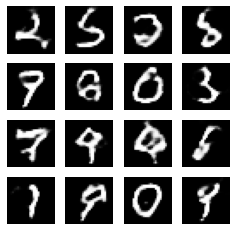

In [35]:
train(trn_data, EPOCHS)

In [36]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [37]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

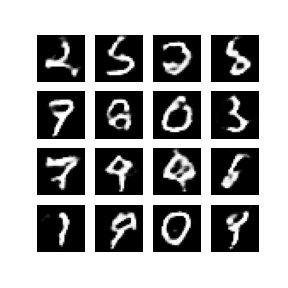

In [38]:
display_image(EPOCHS)